In [13]:
# Select whether to train with Conv2D or Separable Conv2D
train_with_sep = True

In [2]:
# Mounting Google Drive and Authenticating

# Mount google drive to Colab and authenticate
from google.colab import drive
from google.colab import auth
drive.mount('/content/gdrive')
auth.authenticate_user()

# Going into test repository with MimickNet model from Google Drive
%cd gdrive/My Drive/Colab/MimickNet_V2

%ls

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab/MimickNet_V2
example_models/                  MimickNet_Training_NoSC.ipynb  trainer/
log_dir/                         MimickNet_Training_SC.ipynb
MimickNet_Sample_Notebook.ipynb  trained_models/


In [3]:
# Install
%%capture
!pip3 install --upgrade pip
!pip3 install --upgrade tensorflow
!pip3 install tensorflow_datasets
!pip3 install tensorflow_addons==0.8.3
!pip3 install polarTransform
!pip3 install pandas

In [4]:
# Load Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

# Import helpers from Ouwen's MimickNet
from trainer.config import config
from trainer import utils
from trainer import datasets
from trainer import models
from trainer.datasets import MimickNet_NoSC
from trainer.datasets import MimickNet_SC
from trainer.models import MimickNet_Conv
from trainer.models import MimickNet_SepConv
from trainer import callbacks

Unknown args: ['-f', '/root/.local/share/jupyter/runtime/kernel-34b0acc7-ba06-47ed-b3d9-d46c6cca2865.json']
Parsed args: {'bs': 8, 'in_h': 512, 'in_w': 512, 'epochs': 100, 'm': True, 'is_test': False, 'train_csv': 'gs://duke-research-us/mimicknet/data/training-v2.csv', 'train_das_csv': 'gs://duke-research-us/mimicknet/data/training_a-v2.csv', 'train_clinical_csv': 'gs://duke-research-us/mimicknet/data/training_b-v2.csv', 'validation_csv': 'gs://duke-research-us/mimicknet/data/validation-v2.csv', 'test_csv': 'gs://duke-research-us/mimicknet/data/testing-v2.csv', 'clipping': -80.0, 'kernel_height': 3, 'cycle_consistency_loss': 10, 'job_dir': 'gs://duke-research-us/mimicknet/tmp/1604887829.0175838', 'model_dir': './trained_models', 'image_dir': 'gs://duke-research-us/mimicknet/data/duke-ultrasound-v1'}


In [5]:
# Checking versions and misc things
print(tf.__version__)
print(tfa.__version__)
LOG_DIR = "./log_dir"
MODEL_DIR = config.model_dir
print(LOG_DIR)
print(MODEL_DIR)

%rm -r trained_models
%mkdir trained_models

2.3.1
0.8.3
./log_dir
./trained_models


In [6]:
# Create datasets (Train, Validation, Test)
mimick = MimickNet_SC.MimickDataset_SC(divisible=16, bs=config.bs, dataset='duke_ultrasound', data_dir='gs://duke-tfds')

# Information taken from https://www.tensorflow.org/datasets/catalog/duke_ultrasound
train_count = 2556 * config.bs/2
test_count = 438 * config.bs/2
val_count = 278 * config.bs/2

# Make datasets
train_dataset = mimick.make_dataset(dataset_type='train')
validation_dataset = mimick.make_dataset(dataset_type='validation')
test_dataset = mimick.make_dataset(dataset_type='test')

(<tf.Tensor: shape=(), dtype=float32, numpy=0.6602023>, <tf.Tensor: shape=(), dtype=float32, numpy=0.7180176>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9194793>)


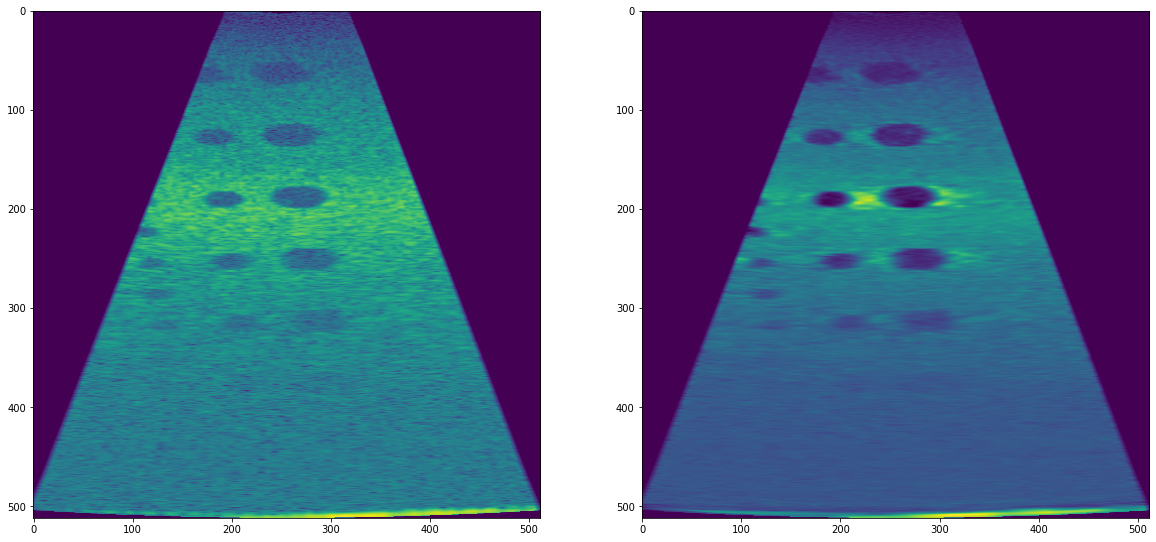

In [7]:
train_iter = iter(train_dataset)
ele_train = next(train_iter)
import matplotlib.pyplot as plt

idx = 5

fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].imshow(tf.squeeze(ele_train[0][idx]))
axes[1].imshow(tf.squeeze(ele_train[1][idx]))
print(utils.custom_ssim(ele_train[0][idx], ele_train[1][idx]))

In [14]:
# Load Model with No Separable Convolutions
from tensorflow.keras.layers import ReLU
# Reset tf session
tf.keras.backend.clear_session()

if train_with_sep == False:
    model = MimickNet_Conv.MimickNet_Conv(shape=(None,None,1),Activation=tf.keras.layers.ReLU(),filters=[16,16,16,16,16], filter_shape=(3,3)).load_model()
else:
    model = MimickNet_SepConv.MimickNet_SepConv(shape=(None,None,1),Activation=tf.keras.layers.ReLU(),filters=[16,16,16,16,16], filter_shape=(3,3)).load_model()

model.compile(optimizer=tf.keras.optimizers.Adam(0.002), loss=utils.custom_mae, 
              metrics=[utils.custom_mae, utils.custom_mse, utils.custom_ssim, utils.psnr])
model.summary()

# Generate Callbacks
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, write_graph=True, update_freq='epoch')
copy_keras = callbacks.CopyKerasModel(MODEL_DIR, LOG_DIR)
saving = tf.keras.callbacks.ModelCheckpoint(MODEL_DIR + '/model.{epoch:02d}-{val_ssim:.10f}.hdf5', 
                                            monitor='val_ssim', verbose=1, save_freq='epoch', mode='max', save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.002*.001)
log_code = callbacks.LogCode(LOG_DIR, './trainer')
terminate = tf.keras.callbacks.TerminateOnNaN()
image_gen = callbacks.GenerateImages(model, validation_dataset, LOG_DIR, interval=int(train_count/config.bs))

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, None, None, 1 41          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 1 0           separable_conv2d[0][0]           
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, None, None, 1 416         activation[0][0]                 
_______________________________________________________________________________________

In [15]:
# Train Model
model.fit(train_dataset,
          steps_per_epoch=int(train_count/config.bs),
          epochs=int(config.epochs/5),
          validation_data=validation_dataset,
          validation_steps=int(val_count/config.bs),
          verbose=1,
          callbacks=[log_code, terminate, tensorboard, reduce_lr, copy_keras])
#           callbacks=[log_code, terminate, tensorboard, saving, reduce_lr, copy_keras])

Epoch 1/20
1278/1278 [==============================] - 1287s 1s/step - loss: 0.0516 - custom_mae: 0.0516 - custom_mse: 0.0066 - custom_ssim: 0.8758 - psnr: 26.7821 - val_loss: 0.0530 - val_custom_mae: 0.0529 - val_custom_mse: 0.0045 - val_custom_ssim: 0.8850 - val_psnr: 26.4072
Epoch 2/20
1278/1278 [==============================] - 1284s 1s/step - loss: 0.0422 - custom_mae: 0.0422 - custom_mse: 0.0032 - custom_ssim: 0.8936 - psnr: 27.9502 - val_loss: 0.0525 - val_custom_mae: 0.0525 - val_custom_mse: 0.0043 - val_custom_ssim: 0.8877 - val_psnr: 26.4532
Epoch 3/20
1278/1278 [==============================] - 1278s 1000ms/step - loss: 0.0412 - custom_mae: 0.0412 - custom_mse: 0.0031 - custom_ssim: 0.8990 - psnr: 28.0583 - val_loss: 0.0514 - val_custom_mae: 0.0514 - val_custom_mse: 0.0041 - val_custom_ssim: 0.8841 - val_psnr: 26.4515
Epoch 4/20
1278/1278 [==============================] - 1262s 987ms/step - loss: 0.0398 - custom_mae: 0.0398 - custom_mse: 0.0028 - custom_ssim: 0.9127 - ps

In [16]:
model.save("./example_models/model_SC_SepConv_v1.h5")